<a href="https://colab.research.google.com/github/jagrutimohanty/CMPE-258-DeepLearning/blob/main/Assignment5/CMPE_258_Taxi_assignment_5_kera_part_a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Name : Jagruti Mohanty**

Assignment5 part a

### About the problem and dataset:

Use NYC's openly available taxi-fare dataset to predict the price of a Taxi ride. Our goal is to use TF as the ML Framework to build a pipeline which should be capable of scaling on infinite data to make an enterprise scale model.

Completed the assignment with help of reference shared and made modifications and additions to the existing code

#Initial Steps for setup

In [ ]:
# Owner - Hasan Rafiq
# Load the TensorBoard notebook extension
%load_ext tensorboard

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import folium

from folium import plugins

import tensorflow as tf
import tensorflow.keras as keras
print(tf.__version__)

device = "gpu"

if device == "tpu":
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
  tf.config.experimental_connect_to_cluster(resolver)
  # This is the TPU initialization code that has to be at the beginning.
  tf.tpu.experimental.initialize_tpu_system(resolver)
  strategy = tf.distribute.experimental.TPUStrategy(resolver)
else:
  strategy = tf.distribute.MultiWorkerMirroredStrategy()

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
2.4.1
INFO:tensorflow:Using MirroredStrategy with devices ('/device:CPU:0',)
INFO:tensorflow:Single-worker MultiWorkerMirroredStrategy with local_devices = ('/device:CPU:0',), communication = CommunicationImplementation.AUTO


In [ ]:
!wget https://raw.githubusercontent.com/tensorflow/tfx/master/tfx/examples/chicago_taxi_pipeline/data/simple/data.csv

--2021-04-24 05:51:13--  https://raw.githubusercontent.com/tensorflow/tfx/master/tfx/examples/chicago_taxi_pipeline/data/simple/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1922812 (1.8M) [text/plain]
Saving to: ‘data.csv.1’

data.csv.1          100%[===================>]   1.83M  --.-KB/s    in 0.08s   

2021-04-24 05:51:14 (23.0 MB/s) - ‘data.csv.1’ saved [1922812/1922812]



#Old data loading step with 15K records

In [ ]:
df = pd.read_csv('/content/data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15002 entries, 0 to 15001
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   pickup_community_area   15000 non-null  float64
 1   fare                    15002 non-null  float64
 2   trip_start_month        15002 non-null  int64  
 3   trip_start_hour         15002 non-null  int64  
 4   trip_start_day          15002 non-null  int64  
 5   trip_start_timestamp    15002 non-null  int64  
 6   pickup_latitude         15000 non-null  float64
 7   pickup_longitude        15000 non-null  float64
 8   dropoff_latitude        14519 non-null  float64
 9   dropoff_longitude       14519 non-null  float64
 10  trip_miles              15002 non-null  float64
 11  pickup_census_tract     1 non-null      float64
 12  dropoff_census_tract    10761 non-null  float64
 13  payment_type            15002 non-null  object 
 14  company                 9862 non-null 

#data preprocessing on older dataset

In [ ]:
df.head()

pickup_community_area   fare  ...  dropoff_community_area  tips
0                    NaN  12.45  ...                     NaN   0.0
1                    NaN   0.00  ...                     NaN   0.0
2                   60.0  27.05  ...                     NaN   0.0
3                   10.0   5.85  ...                     NaN   0.0
4                   14.0  16.65  ...                     NaN   0.0

[5 rows x 18 columns]

In [ ]:
df.nunique()

pickup_community_area        62
fare                        423
trip_start_month             12
trip_start_hour              24
trip_start_day                7
trip_start_timestamp      13789
pickup_latitude             236
pickup_longitude            236
dropoff_latitude            291
dropoff_longitude           291
trip_miles                  530
pickup_census_tract           1
dropoff_census_tract        229
payment_type                  7
company                      61
trip_seconds                110
dropoff_community_area       69
tips                        462
dtype: int64

In [ ]:
df.describe()

pickup_community_area  ...          tips
count           15000.000000  ...  15002.000000
mean               22.250267  ...      1.076674
std                19.414828  ...      2.158340
min                 1.000000  ...      0.000000
25%                 8.000000  ...      0.000000
50%                 8.000000  ...      0.000000
75%                32.000000  ...      2.000000
max                77.000000  ...     47.000000

[8 rows x 16 columns]

In [ ]:
##Drop useless columns Jagruti - removied trip miles
df = df.drop(['trip_start_timestamp','pickup_census_tract',
              'dropoff_census_tract','trip_seconds','payment_type','tips','dropoff_community_area','pickup_community_area'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15002 entries, 0 to 15001
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   fare               15002 non-null  float64
 1   trip_start_month   15002 non-null  int64  
 2   trip_start_hour    15002 non-null  int64  
 3   trip_start_day     15002 non-null  int64  
 4   pickup_latitude    15000 non-null  float64
 5   pickup_longitude   15000 non-null  float64
 6   dropoff_latitude   14519 non-null  float64
 7   dropoff_longitude  14519 non-null  float64
 8   trip_miles         15002 non-null  float64
 9   company            9862 non-null   object 
dtypes: float64(6), int64(3), object(1)
memory usage: 1.1+ MB


# New-added dataset with full dataload 
This dataset is different from the one which was previously used in the sample shared

In [ ]:
#####Jagruti added the actual full load data preprocessed it to get into this format

#Jagruti changing the input since we want the training for more than 15K records 
# load some default Python modules
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

plt.style.use('seaborn-whitegrid')

import warnings
warnings.filterwarnings('ignore')
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

###Jagruti

In [ ]:
#Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

!ls '/content/gdrive/MyDrive/CMPE-258-Jagruti Mohanty/train.csv'

Mounted at /content/gdrive
'/content/gdrive/MyDrive/CMPE-258-Jagruti Mohanty/train.csv'


In [ ]:
train = pd.read_csv('/content/gdrive/MyDrive/CMPE-258-Jagruti Mohanty/train.csv', sep=',',nrows=200000)
train.head()

key  ...  passenger_count
0    2009-06-15 17:26:21.0000001  ...                1
1    2010-01-05 16:52:16.0000002  ...                1
2   2011-08-18 00:35:00.00000049  ...                2
3    2012-04-21 04:30:42.0000001  ...                1
4  2010-03-09 07:51:00.000000135  ...                1

[5 rows x 8 columns]

In [ ]:
print(train.describe())
print("old size: %d" % len(train))
train = train[train.fare_amount >=0]
print("New size: %d" % len(train))
# check missing data
print(train.isnull().sum())

         fare_amount  pickup_longitude  ...  dropoff_latitude  passenger_count
count  200000.000000     200000.000000  ...     199999.000000    200000.000000
mean       11.342877        -72.506121  ...         39.925579         1.682445
std         9.837855         11.608097  ...          6.751120         1.306730
min       -44.900000       -736.550000  ...      -1189.615440         0.000000
25%         6.000000        -73.992050  ...         40.734092         1.000000
50%         8.500000        -73.981743  ...         40.753225         1.000000
75%        12.500000        -73.967068  ...         40.768070         2.000000
max       500.000000       2140.601160  ...        404.616667         6.000000

[8 rows x 6 columns]
old size: 200000
New size: 199987
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64


# New-added Preprocessing for adding time related features
This was not a part of the collab shared

In [ ]:
def prepare_time_features(df):
    df['pickup_datetime'] = df['pickup_datetime'].str.slice(0, 16)
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')
    df['trip_start_hour'] = df.pickup_datetime.dt.hour
#jagruti
#jagruti   

    df['trip_start_month'] = df.pickup_datetime.dt.month
    df["trip_start_day"] = df.pickup_datetime.dt.weekday

    
    return df

In [ ]:
train = prepare_time_features(train)

In [ ]:
##Drop useless columns
train = train.drop(['pickup_datetime','passenger_count','key'], axis=1)

In [ ]:

train.info()
train = train[['fare_amount' ,'trip_start_month' ,'trip_start_hour' ,'trip_start_day' ,'pickup_latitude' ,'pickup_longitude' , 'dropoff_latitude' , 'dropoff_longitude']]


<class 'pandas.core.frame.DataFrame'>
Int64Index: 199987 entries, 0 to 199999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   fare_amount        199987 non-null  float64
 1   pickup_longitude   199987 non-null  float64
 2   pickup_latitude    199987 non-null  float64
 3   dropoff_longitude  199986 non-null  float64
 4   dropoff_latitude   199986 non-null  float64
 5   trip_start_hour    199987 non-null  int64  
 6   trip_start_month   199987 non-null  int64  
 7   trip_start_day     199987 non-null  int64  
dtypes: float64(5), int64(3)
memory usage: 13.7 MB


# Added the new dataset back into the older dataframe with same structure


In [ ]:
train = train.rename(columns={"fare_amount": "fare" ,'trip_start_month':'trip_start_month','trip_start_hour':'trip_start_hour','trip_start_day':'trip_start_day','pickup_latitude':'pickup_latitude','pickup_longitude' :'pickup_longitude' ,'dropoff_latitude' :'dropoff_latitude','dropoff_longitude':'dropoff_longitude'})
train.info()
df=train

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199987 entries, 0 to 199999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   fare               199987 non-null  float64
 1   trip_start_month   199987 non-null  int64  
 2   trip_start_hour    199987 non-null  int64  
 3   trip_start_day     199987 non-null  int64  
 4   pickup_latitude    199987 non-null  float64
 5   pickup_longitude   199987 non-null  float64
 6   dropoff_latitude   199986 non-null  float64
 7   dropoff_longitude  199986 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 13.7 MB


In [ ]:
#Drop NA rows
df = df.dropna()

#Drop rows where FARE > 200( only 1 row found )
df = df.drop(df[df['fare'] > 200].index)
#jsgruti
#df = df.drop(["company"],axis=1)
#
#Change datatype of cols
df['trip_start_month'] = df['trip_start_month'].astype('str')
df['trip_start_hour'] = df['trip_start_hour'].astype('str')
df['trip_start_day'] = df['trip_start_day'].astype('str')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199979 entries, 0 to 199999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   fare               199979 non-null  float64
 1   trip_start_month   199979 non-null  object 
 2   trip_start_hour    199979 non-null  object 
 3   trip_start_day     199979 non-null  object 
 4   pickup_latitude    199979 non-null  float64
 5   pickup_longitude   199979 non-null  float64
 6   dropoff_latitude   199979 non-null  float64
 7   dropoff_longitude  199979 non-null  float64
dtypes: float64(5), object(3)
memory usage: 13.7+ MB


In [ ]:
##Train test split ( Original DF )
np.random.seed(seed=2)
msk = np.random.rand(len(df)) < 0.85
traindf = df[msk]
evaldf = df[~msk]

print(len(traindf))
print(len(evaldf))

traindf.to_csv("train.csv", index=False, header=False)
evaldf.to_csv("eval.csv", index=False, header=False)

169887
30092


In [ ]:
##Train test split ( Original DF )
np.random.seed(seed=2)
msk = np.random.rand(len(df)) < 0.85
traindf = df[msk]
evaldf = df[~msk]

print(len(traindf))
print(len(evaldf))

traindf.to_csv("train.csv", index=False, header=False)
evaldf.to_csv("eval.csv", index=False, header=False)

169887
30092


#data exploration

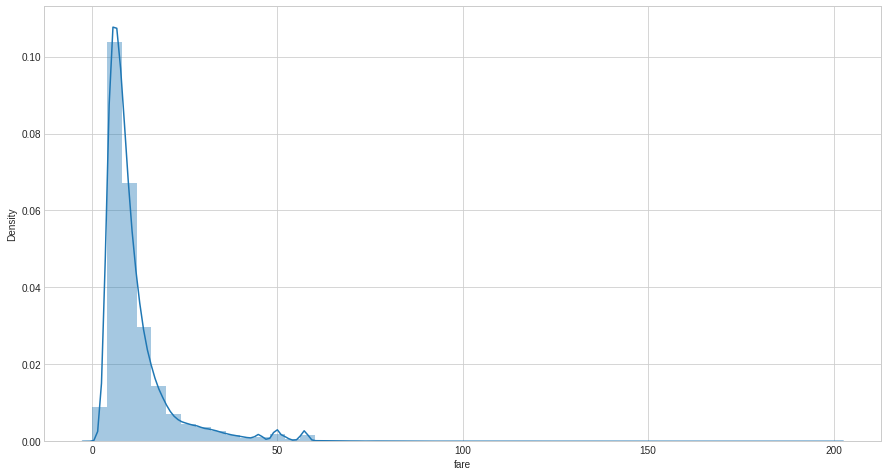

In [ ]:
##Distribution of Fare
plt.figure(figsize=(15, 8))
sns.distplot(traindf['fare'])

In [ ]:
##Plot locations with heatmap intensity as per the FARE
m = folium.Map()
sw = traindf[['pickup_latitude', 'pickup_longitude']].min().values.tolist()
ne = traindf[['pickup_latitude', 'pickup_longitude']].max().values.tolist()
m.add_child(plugins.HeatMap(zip(traindf['pickup_latitude'], traindf['pickup_longitude'], traindf['fare']), radius = 10))
m.fit_bounds([sw, ne])
m

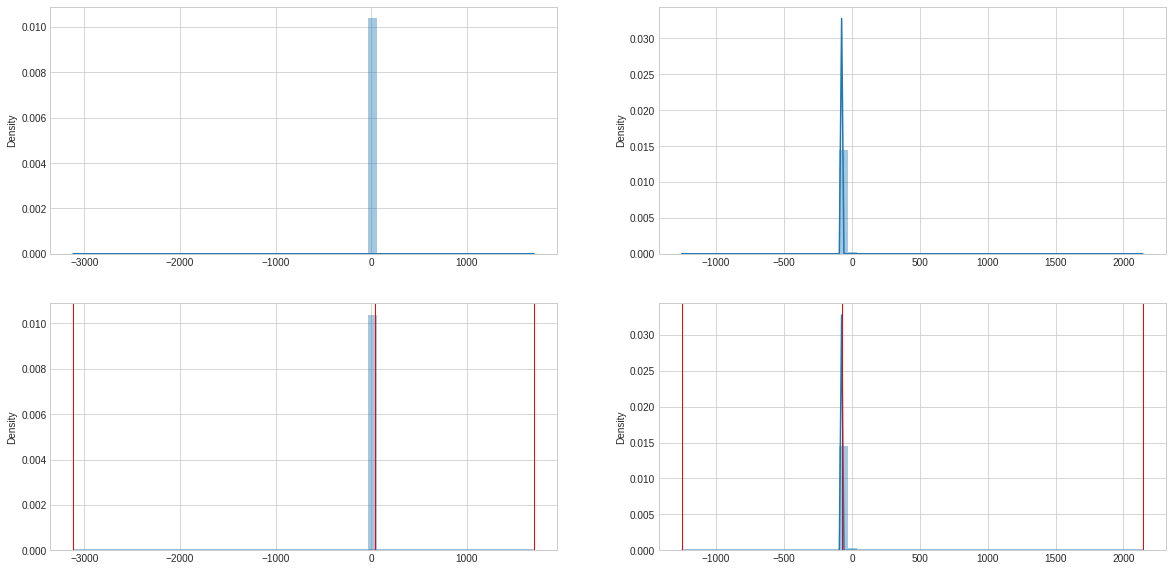

In [ ]:
##Quantile Bucketization of latitude and longitude
# bins_lat = np.linspace(np.min([np.min(df['dropoff_latitude']),np.min(df['pickup_latitude'])]),
#             np.max([np.max(df['dropoff_latitude']),np.max(df['pickup_latitude'])]),
#             20)
bins_lat = pd.qcut(list(df['dropoff_latitude'].values) + list(df['pickup_latitude'].values), q=20, duplicates='drop', retbins=True)[1]

# bins_lon = np.linspace(np.min([np.min(df['dropoff_longitude']),np.min(df['pickup_longitude'])]),
#             np.max([np.max(df['dropoff_longitude']),np.max(df['pickup_longitude'])]),
#             20)
bins_lon = pd.qcut(list(df['dropoff_longitude'].values) + list(df['pickup_longitude'].values), q=20, duplicates='drop', retbins=True)[1]

#Plot all latitude values with bins
f, axes = plt.subplots(2, 2, figsize=(20, 10), sharex=False)
sns.distplot(list(df['dropoff_latitude'].values) + list(df['pickup_latitude'].values), ax=axes[0, 0])
sns.distplot(list(df['dropoff_longitude'].values) + list(df['pickup_longitude'].values), ax=axes[0, 1])

#Plot bins
sns.distplot(list(df['dropoff_latitude'].values) + list(df['pickup_latitude'].values), ax=axes[1, 0])
sns.distplot(list(df['dropoff_longitude'].values) + list(df['pickup_longitude'].values), ax=axes[1, 1])
for b_ in bins_lat:
  axes[1][0].axvline(b_, color='red', linewidth=1 )
for b_ in bins_lon:
  axes[1][1].axvline(b_, color='red', linewidth=1 )

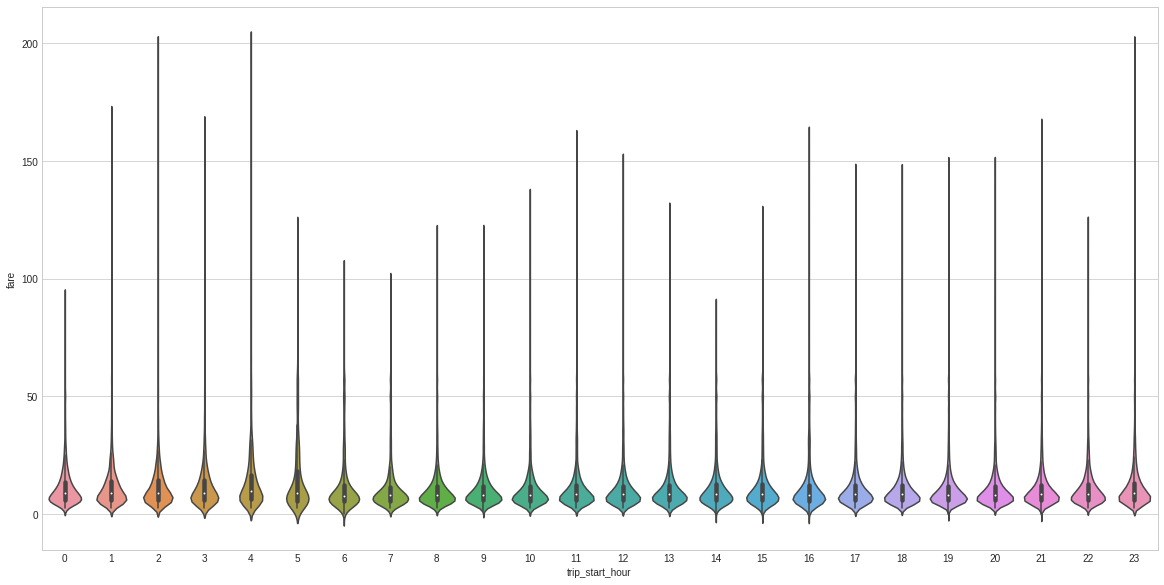

In [ ]:

plt.figure(figsize=(20, 10))
sns.violinplot(x=traindf['trip_start_hour'].astype(int), y=traindf['fare'])

#New-added data visualization

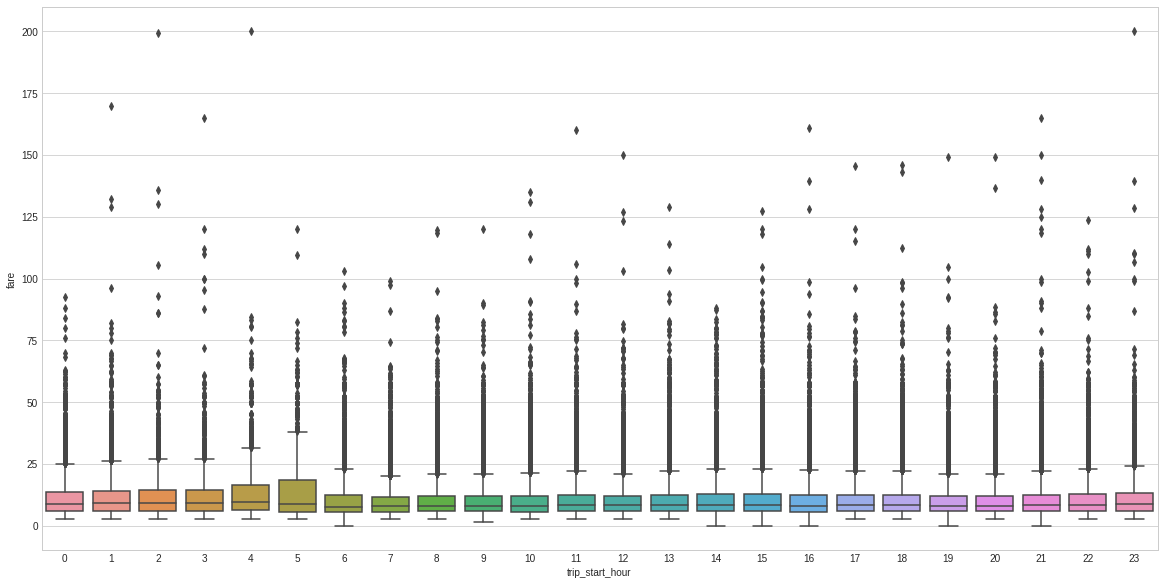

In [ ]:
#jagruti
plt.figure(figsize=(20, 10))
sns.boxplot(x=traindf['trip_start_hour'].astype(int), y=traindf['fare'])

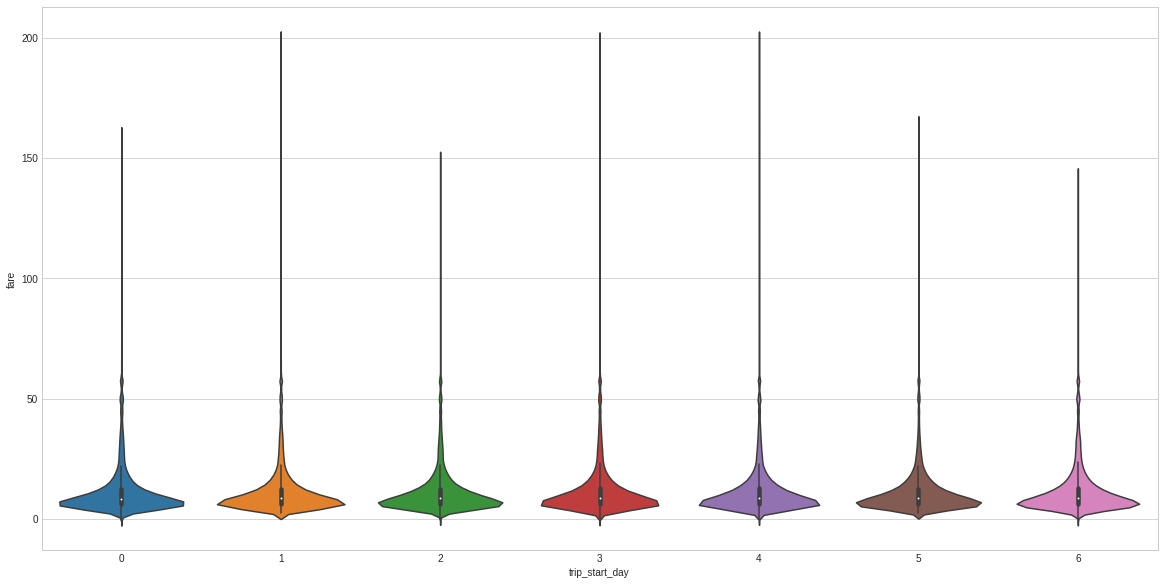

In [ ]:
plt.figure(figsize=(20, 10))
sns.violinplot(x=traindf['trip_start_day'].astype(int), y=traindf['fare'])

# New-added data visualization

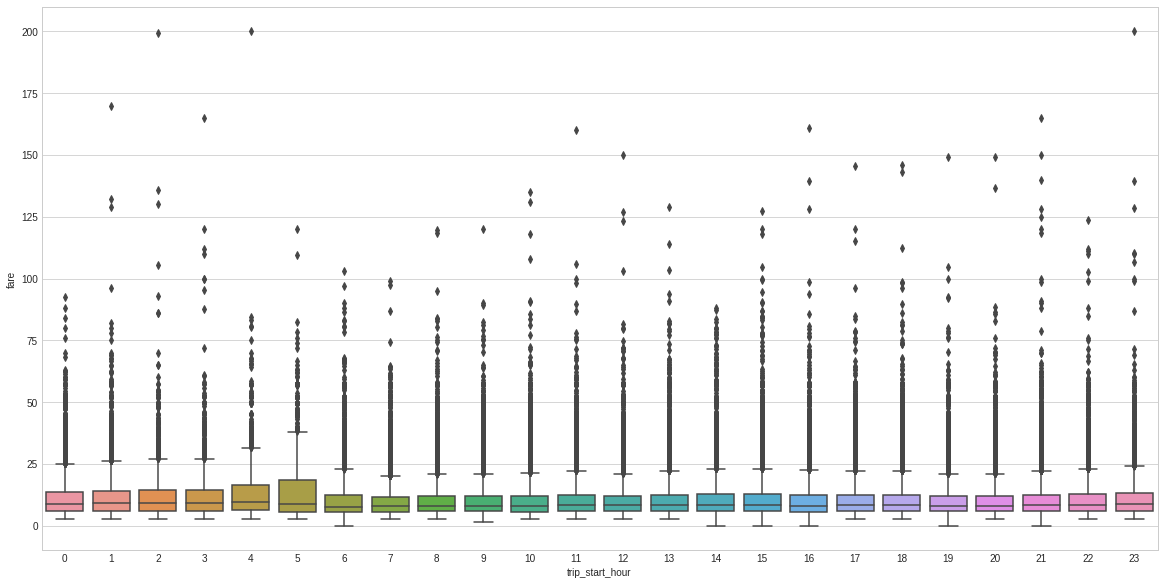

In [ ]:
#jagruti

plt.figure(figsize=(20, 10))
sns.boxplot(x=traindf['trip_start_hour'].astype(int), y=traindf['fare'])

# New-added data visualization

Text(0.5, 1.0, 'Histogram of start hour')

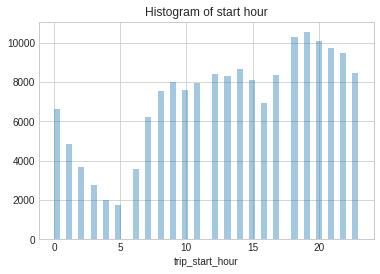

In [ ]:
#jagruti
sns.distplot(traindf['trip_start_hour'].astype(int), kde =False).set_title("Histogram of start hour")


In [ ]:
traindf

fare trip_start_month  ... dropoff_latitude dropoff_longitude
0        4.50                6  ...        40.712278        -73.841610
1       16.90                1  ...        40.782004        -73.979268
2        5.70                8  ...        40.750562        -73.991242
3        7.70                4  ...        40.758092        -73.991567
4        5.30                3  ...        40.783762        -73.956655
...       ...              ...  ...              ...               ...
199994   9.00                9  ...        40.692645        -73.959871
199995   8.90                3  ...        40.758504        -73.990683
199996  14.10                6  ...        40.766701        -73.961319
199997   6.90                8  ...        40.732282        -74.003508
199999  42.83                1  ...        40.770958        -73.865578

[169887 rows x 8 columns]

# New-added data visualization

Text(0.5, 1.0, 'Histogram of fare price')

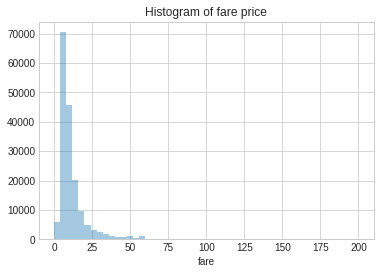

In [ ]:
#jagruti
#jagruti
sns.distplot(traindf['fare'].astype(int), kde =False).set_title("Histogram of fare price")


New-added data visualization

Text(0.5, 1.0, 'Histogram of trip distrubution on start days')

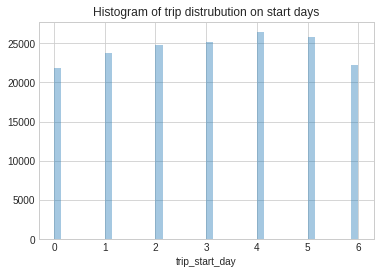

In [ ]:
#jagruti
#jagruti

sns.distplot(traindf['trip_start_day'].astype(int), kde =False).set_title("Histogram of trip distrubution on start days")


New-added data visualization

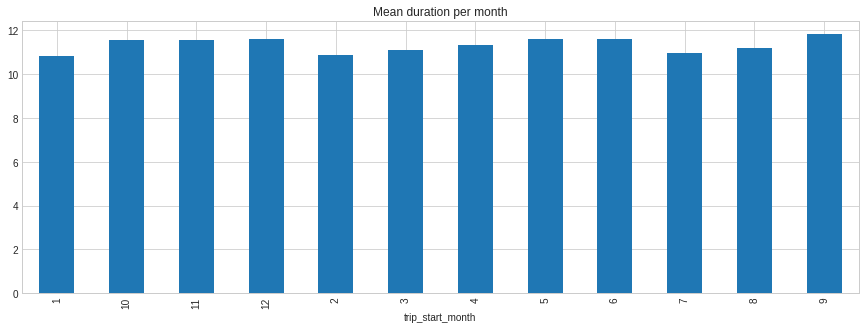

In [ ]:
#jagruti
traindf.groupby(['trip_start_month'])['fare'].mean().plot(kind='bar', figsize=(15, 5));
plt.title('Mean duration per month');

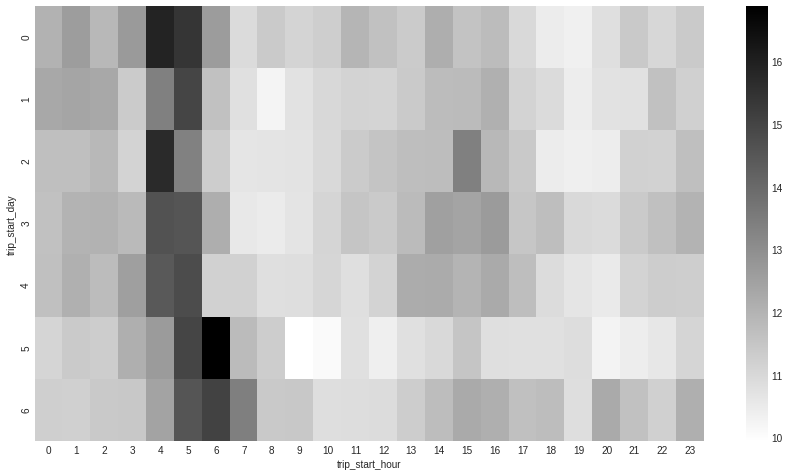

In [ ]:
##Average trip fare( day & hour combined )
plt.figure(figsize=(15, 8))
cross = pd.crosstab(traindf['trip_start_day'] , pd.to_numeric(traindf['trip_start_hour']) , traindf['fare'], aggfunc=np.average)
sns.heatmap(cross, annot=False, fmt='g', cmap='binary')

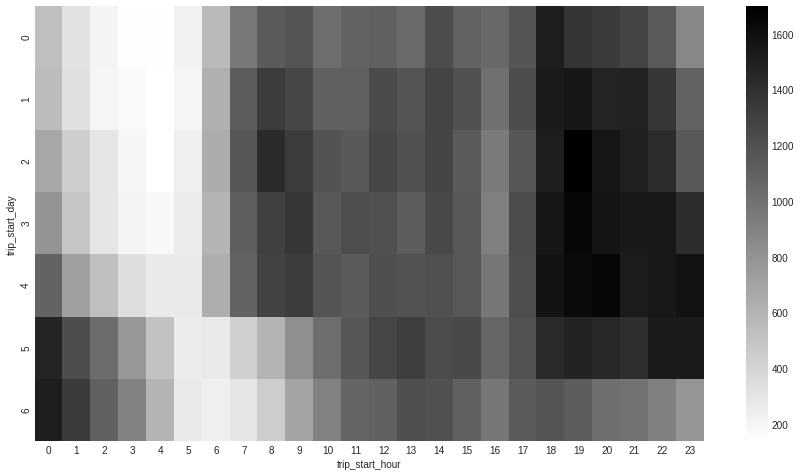

In [ ]:
##Number of trips( day-hour wise )
plt.figure(figsize=(15, 8))
cross = pd.crosstab(traindf['trip_start_day'] , pd.to_numeric(traindf['trip_start_hour']) , traindf.index , aggfunc='count')
sns.heatmap(cross, annot=False, fmt='g', cmap='binary')

Feature engineering exploration:

In [ ]:
##Calculate Euclidean distance
from scipy.spatial import distance
def euclidean(row):
  # print(row)
  a = (row['pickup_latitude'], row['pickup_longitude'])
  b = (row['dropoff_latitude'], row['dropoff_longitude'])
  row['distance'] = distance.euclidean(a, b) * 100
  return row

traindf = traindf.apply(euclidean, axis=1)
traindf.head() 

fare trip_start_month  ... dropoff_longitude  distance
0   4.5                6  ...        -73.841610  0.943584
1  16.9                1  ...        -73.979268  7.969567
2   5.7                8  ...        -73.991242  1.367404
3   7.7                4  ...        -73.991567  2.534047
4   5.3                3  ...        -73.956655  1.946952

[5 rows x 9 columns]

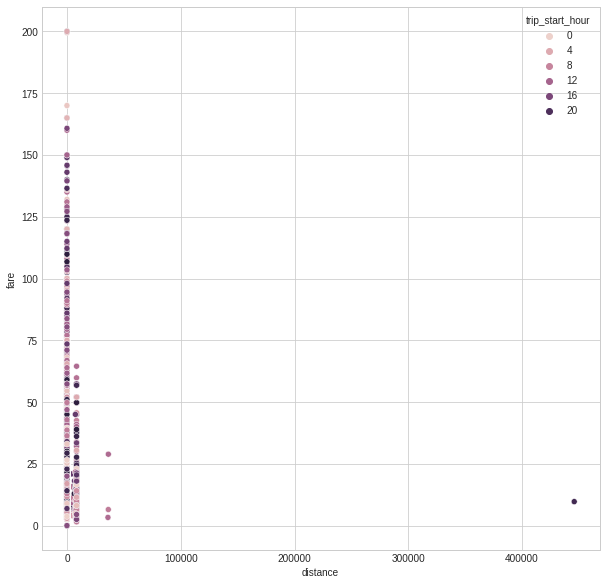

In [ ]:
##Fair Vs distance plot( Colored by Trip Start Hour )
plt.figure(figsize=(10, 10))
sns.scatterplot(x=traindf['distance'], y=traindf['fare'], hue=traindf['trip_start_hour'].astype(int))

# New-added data visualization

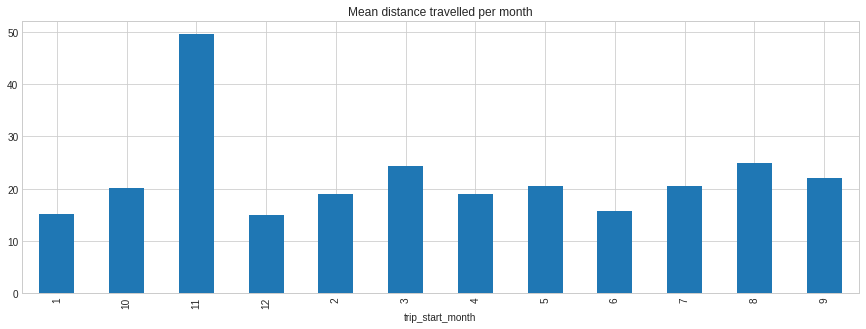

In [ ]:
#jagruti
traindf.groupby(['trip_start_month'])['distance'].mean().plot(kind='bar', figsize=(15, 5));
plt.title('Mean distance travelled per month');

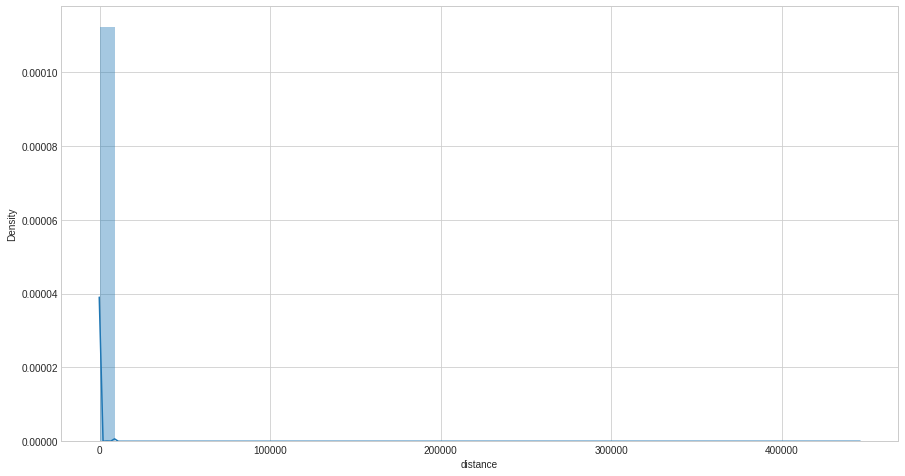

In [ ]:
plt.figure(figsize=(15, 8))
sns.distplot(traindf['distance'])

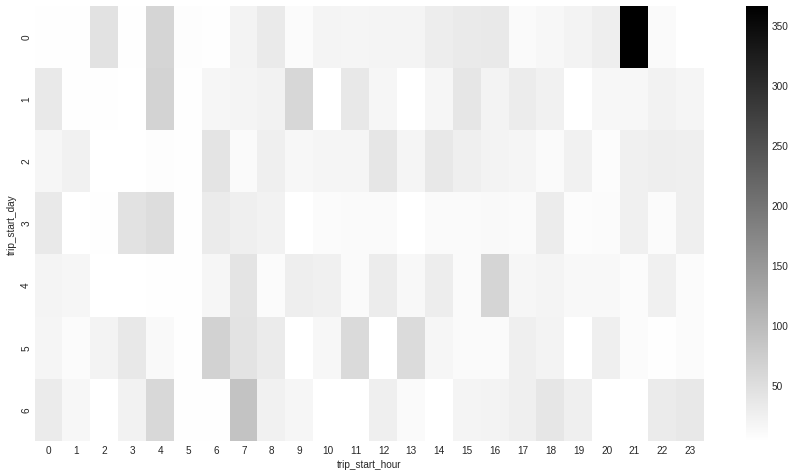

In [ ]:
##Average trip distance( day-hour wise )
plt.figure(figsize=(15, 8))
cross = pd.crosstab(traindf['trip_start_day'] , pd.to_numeric(traindf['trip_start_hour']) , traindf['distance'], aggfunc=np.average)
sns.heatmap(cross, annot=False, fmt='g', cmap='binary')

In [ ]:
df
#jagrut check the numerical columns and do this step

fare trip_start_month  ... dropoff_latitude dropoff_longitude
0        4.50                6  ...        40.712278        -73.841610
1       16.90                1  ...        40.782004        -73.979268
2        5.70                8  ...        40.750562        -73.991242
3        7.70                4  ...        40.758092        -73.991567
4        5.30                3  ...        40.783762        -73.956655
...       ...              ...  ...              ...               ...
199995   8.90                3  ...        40.758504        -73.990683
199996  14.10                6  ...        40.766701        -73.961319
199997   6.90                8  ...        40.732282        -74.003508
199998  18.00               11  ...        40.785599        -73.978532
199999  42.83                1  ...        40.770958        -73.865578

[199979 rows x 8 columns]

#New-added data normalization step for the latitude longitude pickup and drop features

In [ ]:
#Jagruti Add Normalization step for numerical data 

#Normalizing 

from pandas.api.types import is_numeric_dtype

#"Compute the means and stds of `self.cont_names` columns to normalize them."
def Normalize(df):
  means,stds = {},{}
  cont_names = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']
  for n in cont_names:
    assert is_numeric_dtype(df[n]), (f"""Cannot normalize '{n}' column as it isn't numerical. Are you sure it doesn't belong in the categorical set of columns?""")
    means[n],stds[n] = df[n].mean(),df[n].std()
    df[n] = (df[n]-means[n]) / (1e-7 + stds[n])


Normalize(df)




In [ ]:
df

fare trip_start_month  ... dropoff_latitude dropoff_longitude
0        4.50                6  ...         0.116455         -0.123285
1       16.90                1  ...         0.126787         -0.136126
2        5.70                8  ...         0.122128         -0.137243
3        7.70                4  ...         0.123244         -0.137274
4        5.30                3  ...         0.127047         -0.134017
...       ...              ...  ...              ...               ...
199995   8.90                3  ...         0.123305         -0.137191
199996  14.10                6  ...         0.124519         -0.134452
199997   6.90                8  ...         0.119419         -0.138387
199998  18.00               11  ...         0.127319         -0.136058
199999  42.83                1  ...         0.125150         -0.125521

[199979 rows x 8 columns]

In [ ]:
##Train test split ( Original DF )
np.random.seed(seed=2)
msk = np.random.rand(len(df)) < 0.85
traindf = df[msk]
evaldf = df[~msk]

print(len(traindf))
print(len(evaldf))

traindf.to_csv("train.csv", index=False, header=False)
evaldf.to_csv("eval.csv", index=False, header=False)
traindf.head()

169887
30092


fare trip_start_month  ... dropoff_latitude dropoff_longitude
0   4.5                6  ...         0.116455         -0.123285
1  16.9                1  ...         0.126787         -0.136126
2   5.7                8  ...         0.122128         -0.137243
3   7.7                4  ...         0.123244         -0.137274
4   5.3                3  ...         0.127047         -0.134017

[5 rows x 8 columns]

In [ ]:
###############################
##Feature engineering functions
def feature_engg_features(features):
  #Add new features
  features['distance'] = ((features['pickup_latitude'] - features['dropoff_latitude'])**2 +  (features['pickup_longitude'] - features['dropoff_longitude'])**2)**0.5

  return(features)

#To be called from TF
def feature_engg(features, label):
  #Add new features
  features = feature_engg_features(features)

  return(features, label)  

In [ ]:
traindf.columns

Index(['fare', 'trip_start_month', 'trip_start_hour', 'trip_start_day',
       'pickup_latitude', 'pickup_longitude', 'dropoff_latitude',
       'dropoff_longitude'],
      dtype='object')

In [ ]:
###############################
###Data Input pipeline function

# Determine CSV, label, and key columns
#Columns in training sheet -> Can have extra columns too
CSV_COLUMNS = traindf.columns
LABEL_COLUMN = 'fare'

# Set default values for each CSV column( Including Y column )
DEFAULTS = [[0.0], ['1'], ['1'],['1'],[0.0],[0.0],[0.0],[0.0]]

def make_input_fn(filename, mode, vnum_epochs = None, batch_size = 512):
    def _input_fn(v_test=False):     
        # Create list of files that match pattern
        file_list = tf.io.gfile.glob(filename)

        if mode == tf.estimator.ModeKeys.TRAIN:
            num_epochs = vnum_epochs # indefinitely
        else:
            num_epochs = 1 # end-of-input after this        
        
        # Create dataset from file list
        dataset = tf.compat.v1.data.experimental.make_csv_dataset(file_list,
                                                   batch_size=batch_size,
                                                   column_names=CSV_COLUMNS,
                                                   column_defaults=DEFAULTS,
                                                   label_name=LABEL_COLUMN,
                                                   num_epochs = num_epochs,
                                                   num_parallel_reads=30)
        
        dataset = dataset.prefetch(buffer_size = batch_size)

        #Feature engineering
        dataset = dataset.map(feature_engg)

        if mode == tf.estimator.ModeKeys.TRAIN:
            num_epochs = vnum_epochs # indefinitely
            dataset = dataset.shuffle(buffer_size = batch_size)
        else:
            num_epochs = 1 # end-of-input after this

        dataset = dataset.repeat(num_epochs)       
        
        #Begins - Uncomment for testing only -----------------------------------------------------<
        if v_test == True:
          print(next(dataset.__iter__()))
          
        #End - Uncomment for testing only -----------------------------------------------------<
        return dataset
    return _input_fn

In [ ]:
#Test dataset read + Feat Engg function's - output's CSV + Feature engg columns

eval_file = "train*.csv"
fn_d = make_input_fn(filename = eval_file,
                    mode = tf.estimator.ModeKeys.EVAL,
                    # vnum_epochs = 1,
                    batch_size = 10)

fn_d(v_test=True)

(OrderedDict([('trip_start_month', <tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'11', b'8', b'10', b'6', b'7', b'5', b'11', b'8', b'9', b'1'],
      dtype=object)>), ('trip_start_hour', <tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'11', b'13', b'2', b'16', b'9', b'18', b'15', b'11', b'7', b'22'],
      dtype=object)>), ('trip_start_day', <tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'2', b'0', b'4', b'1', b'1', b'0', b'4', b'3', b'5', b'2'],
      dtype=object)>), ('pickup_latitude', <tf.Tensor: shape=(10,), dtype=float32, numpy=
array([ 0.08540857,  0.08230425,  0.08331836,  0.08275896,  0.08115371,
        0.08370579, -3.9731019 ,  0.08001302,  0.08299264,  0.08462953],
      dtype=float32)>), ('pickup_longitude', <tf.Tensor: shape=(10,), dtype=float32, numpy=
array([-0.1251134 , -0.1262191 , -0.12698375, -0.12794098, -0.12724733,
       -0.12621695,  6.2477546 , -0.12741855, -0.12811737, -0.1250336 ],
      dtype=float32)>), ('dropoff_latitude', <tf.Tensor:

<DatasetV1Adapter shapes: (OrderedDict([(trip_start_month, (None,)), (trip_start_hour, (None,)), (trip_start_day, (None,)), (pickup_latitude, (None,)), (pickup_longitude, (None,)), (dropoff_latitude, (None,)), (dropoff_longitude, (None,)), (distance, (None,))]), (None,)), types: (OrderedDict([(trip_start_month, tf.string), (trip_start_hour, tf.string), (trip_start_day, tf.string), (pickup_latitude, tf.float32), (pickup_longitude, tf.float32), (dropoff_latitude, tf.float32), (dropoff_longitude, tf.float32), (distance, tf.float32)]), tf.float32)>

In [ ]:
traindf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 169887 entries, 0 to 199999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   fare               169887 non-null  float64
 1   trip_start_month   169887 non-null  object 
 2   trip_start_hour    169887 non-null  object 
 3   trip_start_day     169887 non-null  object 
 4   pickup_latitude    169887 non-null  float64
 5   pickup_longitude   169887 non-null  float64
 6   dropoff_latitude   169887 non-null  float64
 7   dropoff_longitude  169887 non-null  float64
dtypes: float64(5), object(3)
memory usage: 11.7+ MB


In [ ]:
# Define feature columns(Including feature engineered ones )
# These are the features which come from the TF Data pipeline
def create_feature_cols():
    #Keras format features
    k_month = tf.keras.Input(name='trip_start_month', shape=(1,), dtype=tf.string)
    k_hour  = tf.keras.Input(name='trip_start_hour', shape=(1,), dtype=tf.string)
    k_day  = tf.keras.Input(name='trip_start_day', shape=(1,), dtype=tf.string)
    k_picklat  = tf.keras.Input(name='pickup_latitude', shape=(1,), dtype=tf.float32)
    k_picklon  = tf.keras.Input(name='pickup_longitude', shape=(1,), dtype=tf.float32)
    k_droplat  = tf.keras.Input(name='dropoff_latitude', shape=(1,), dtype=tf.float32)
    k_droplon  = tf.keras.Input(name='dropoff_longitude', shape=(1,), dtype=tf.float32)
   # k_miles = tf.keras.Input(name='trip_miles', shape=(1,), dtype=tf.float32)
    k_distance  = tf.keras.Input(name='distance', shape=(1,), dtype=tf.float32)
    keras_dict_input = {'trip_start_month': k_month, 'trip_start_hour': k_hour, 'trip_start_day' : k_day,
                        'pickup_latitude': k_picklat, 'pickup_longitude': k_picklon,
                        'dropoff_latitude': k_droplat, 
                        'dropoff_longitude': k_droplon,
                       # 'trip_miles' : k_miles, 
                        'distance' : k_distance
                        }

    return({'K' : keras_dict_input})

create_feature_cols()

{'K': {'distance': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'distance')>,
  'dropoff_latitude': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dropoff_latitude')>,
  'dropoff_longitude': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dropoff_longitude')>,
  'pickup_latitude': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'pickup_latitude')>,
  'pickup_longitude': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'pickup_longitude')>,
  'trip_start_day': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'trip_start_day')>,
  'trip_start_hour': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'trip_start_hour')>,
  'trip_start_month': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'trip_start_month')>}}

# Modified the parameters of the model

In [ ]:
#Create model # ajgruti changed beta 1 0.98 and decay : 0.02
params_default = {
    'lr' : 0.001,
    'beta_1' : 0.98,
    'beta_2' : 0.999,
    'epsilon' : 1e-08,
    'decay' : 0.02,
    'hidden_layers' : 1
}

##Feature Engineering
# def featengg_funcs(inp):
#     #Add all calculations, pass out as concatenate
#     vpatd_squared = inp[1] * inp[1]
#     vpatd_neg = -1 * inp[1]

#     return keras.layers.concatenate([vpatd_squared, vpatd_neg], axis = 1)

def create_keras_model(params, feature_cols):
    METRICS = [
            keras.metrics.RootMeanSquaredError(name='rmse')
    ]

    #Input layers
    input_feats = []
    for inp in feature_cols['K'].keys():
      input_feats.append(feature_cols['K'][inp])

    ##Input processing
    ##https://keras.io/examples/structured_data/structured_data_classification_from_scratch/
    ##https://github.com/tensorflow/community/blob/master/rfcs/20191212-keras-categorical-inputs.md

    ##Handle categorical attributes( One-hot encoding )
    cat_day = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=['1','2','3','4','5','6','7'], mask_token=None)(feature_cols['K']['trip_start_day'])
    cat_day = tf.keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens=7)(cat_day)

    cat_hour = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=['1','2','3','4','5','6','7','8'
                                                                                      '9','10','11','12','13','14','15','16',
                                                                                      '17','18','19','20','21','22','23','0'
                                                                                      ], mask_token=None)(feature_cols['K']['trip_start_hour'])
    cat_hour = tf.keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens=24)(cat_hour)

    cat_month = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=['1','2','3','4','5','6','7','8'
                                                                                      '9','10','11','12'], mask_token=None)(feature_cols['K']['trip_start_month'])
    cat_month = tf.keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens=12)(cat_month)

    # cat_company = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=df['company'].unique(), mask_token=None)(feature_cols['K']['company'])
    # cat_company = tf.keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens=len(df['company'].unique()))(cat_company)

    ##Binning
    bins_pickup_lat = tf.keras.layers.experimental.preprocessing.Discretization(bins = bins_lat)(feature_cols['K']['pickup_latitude'])
    cat_pickup_lat = tf.keras.layers.experimental.preprocessing.CategoryEncoding(len(bins_lat)+1)(bins_pickup_lat)

    bins_pickup_lon = tf.keras.layers.experimental.preprocessing.Discretization(bins = bins_lon)(feature_cols['K']['pickup_longitude'])
    cat_pickup_lon = tf.keras.layers.experimental.preprocessing.CategoryEncoding(len(bins_lon)+1)(bins_pickup_lon)

    bins_drop_lat = tf.keras.layers.experimental.preprocessing.Discretization(bins = bins_lat)(feature_cols['K']['dropoff_latitude'])
    cat_drop_lat = tf.keras.layers.experimental.preprocessing.CategoryEncoding(len(bins_lat)+1)(bins_drop_lat)

    bins_drop_lon = tf.keras.layers.experimental.preprocessing.Discretization(bins = bins_lon)(feature_cols['K']['dropoff_longitude'])
    cat_drop_lon = tf.keras.layers.experimental.preprocessing.CategoryEncoding(len(bins_lon)+1)(bins_drop_lon)

    ##Categorical cross
    cross_day_hour = tf.keras.layers.experimental.preprocessing.CategoryCrossing()([cat_day, cat_hour])
    hash_cross_day_hour = tf.keras.layers.experimental.preprocessing.Hashing(num_bins=24 * 7)(cross_day_hour)
    cat_cross_day_hour = tf.keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens = 24* 7)(hash_cross_day_hour)

    cross_pick_lon_lat = tf.keras.layers.experimental.preprocessing.CategoryCrossing()([cat_pickup_lat, cat_pickup_lon])
    hash_cross_pick_lon_lat = tf.keras.layers.experimental.preprocessing.Hashing(num_bins=(len(bins_lat) + 1) ** 2)(cross_pick_lon_lat)

    cross_drop_lon_lat = tf.keras.layers.experimental.preprocessing.CategoryCrossing()([cat_drop_lat, cat_drop_lon])
    hash_cross_drop_lon_lat = tf.keras.layers.experimental.preprocessing.Hashing(num_bins=(len(bins_lat) + 1) ** 2)(cross_drop_lon_lat)

    # Cross to embedding
    embed_cross_pick_lon_lat = tf.keras.layers.Embedding(((len(bins_lat) + 1) ** 2), 4)(hash_cross_pick_lon_lat)
    embed_cross_pick_lon_lat = tf.reduce_sum(embed_cross_pick_lon_lat, axis=-2)

    embed_cross_drop_lon_lat = tf.keras.layers.Embedding(((len(bins_lat) + 1) ** 2), 4)(hash_cross_drop_lon_lat)
    embed_cross_drop_lon_lat = tf.reduce_sum(embed_cross_drop_lon_lat, axis=-2)

    # Also pass time attributes as Deep signal( Cast to integer )
    int_trip_start_day = tf.strings.to_number(feature_cols['K']['trip_start_day'], tf.float32)
    int_trip_start_hour = tf.strings.to_number(feature_cols['K']['trip_start_hour'], tf.float32)
    int_trip_start_month = tf.strings.to_number(feature_cols['K']['trip_start_month'], tf.float32)

    #Add feature engineered columns - LAMBDA layer

    ###Create MODEL
    ####Concatenate all features( Numerical input )
    x_input_numeric = tf.keras.layers.concatenate([
                    feature_cols['K']['pickup_latitude'], feature_cols['K']['pickup_longitude'],
                    feature_cols['K']['dropoff_latitude'], feature_cols['K']['dropoff_longitude'],
                    feature_cols['K']['distance'], embed_cross_pick_lon_lat, embed_cross_drop_lon_lat,
                    int_trip_start_day, int_trip_start_hour, int_trip_start_month
                    ])

    #DEEP - This Dense layer connects to input layer - Numeric Data
    x_numeric = tf.keras.layers.Dense(32, activation='relu', kernel_initializer="he_uniform")(x_input_numeric)
    x_numeric = tf.keras.layers.BatchNormalization()(x_numeric)

    ####Concatenate all Categorical features( Categorical converted )
    x_input_categ = tf.keras.layers.concatenate([
                    cat_month, cat_cross_day_hour, cat_pickup_lat, cat_pickup_lon,
                    cat_drop_lat, cat_drop_lon
                    ])
    
    #WIDE - This Dense layer connects to input layer - Categorical Data
    x_categ = tf.keras.layers.Dense(32, activation='relu', kernel_initializer="he_uniform")(x_input_categ)

    ####Concatenate both Wide and Deep layers
    x = tf.keras.layers.concatenate([x_categ, x_numeric])

    for l_ in range(params['hidden_layers']):
        x = tf.keras.layers.Dense(32, activation='relu', kernel_initializer="he_uniform",
                                  activity_regularizer=tf.keras.regularizers.l2(0.00001))(x)
        x = tf.keras.layers.BatchNormalization()(x)

    #Final Layer
    out = tf.keras.layers.Dense(1, activation='relu')(x)
    model = tf.keras.Model(input_feats, out)

    #Set optimizer
    opt = tf.keras.optimizers.Adam(lr= params['lr'], beta_1=params['beta_1'], 
                                        beta_2=params['beta_2'], epsilon=params['epsilon'])

    #Compile model
    model.compile(loss='mean_squared_error',  optimizer=opt, metrics = METRICS)

    #Print Summary
    print(model.summary())
    return model

# Modified the paramters of the model

In [ ]:
#Jagruti change parameters for patience = 5 min_lr = 0.00002
def keras_train_and_evaluate(model, train_dataset, validation_dataset, epochs=100):
  #Add callbacks
  reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                patience=5, min_lr=0.00002, verbose = 1)
  
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")

  #Train and Evaluate
  out = model.fit(train_dataset, 
                  validation_data = validation_dataset,
                  epochs=epochs,
                  # validation_steps = 3,   ###Keep this none for running evaluation on full EVAL data every epoch
                  steps_per_epoch = 100,   ###Has to be passed - Cant help it :) [ Number of batches per epoch ]
                  callbacks=[reduce_lr, #modelsave_callback, #tensorboard_callback, 
                             keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True, verbose=True)]
  )

# Modified the data validation batch size

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
pickup_latitude (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
pickup_longitude (InputLayer)   [(None, 1)]          0                                            
__________________________________________________________________________________________________
dropoff_latitude (InputLayer)   [(None, 1)]          0                                            
__________________________________________________________________________________________________
dropoff_longitude (InputLayer)  [(None, 1)]          0                                            
______________________________________________________________________________________________

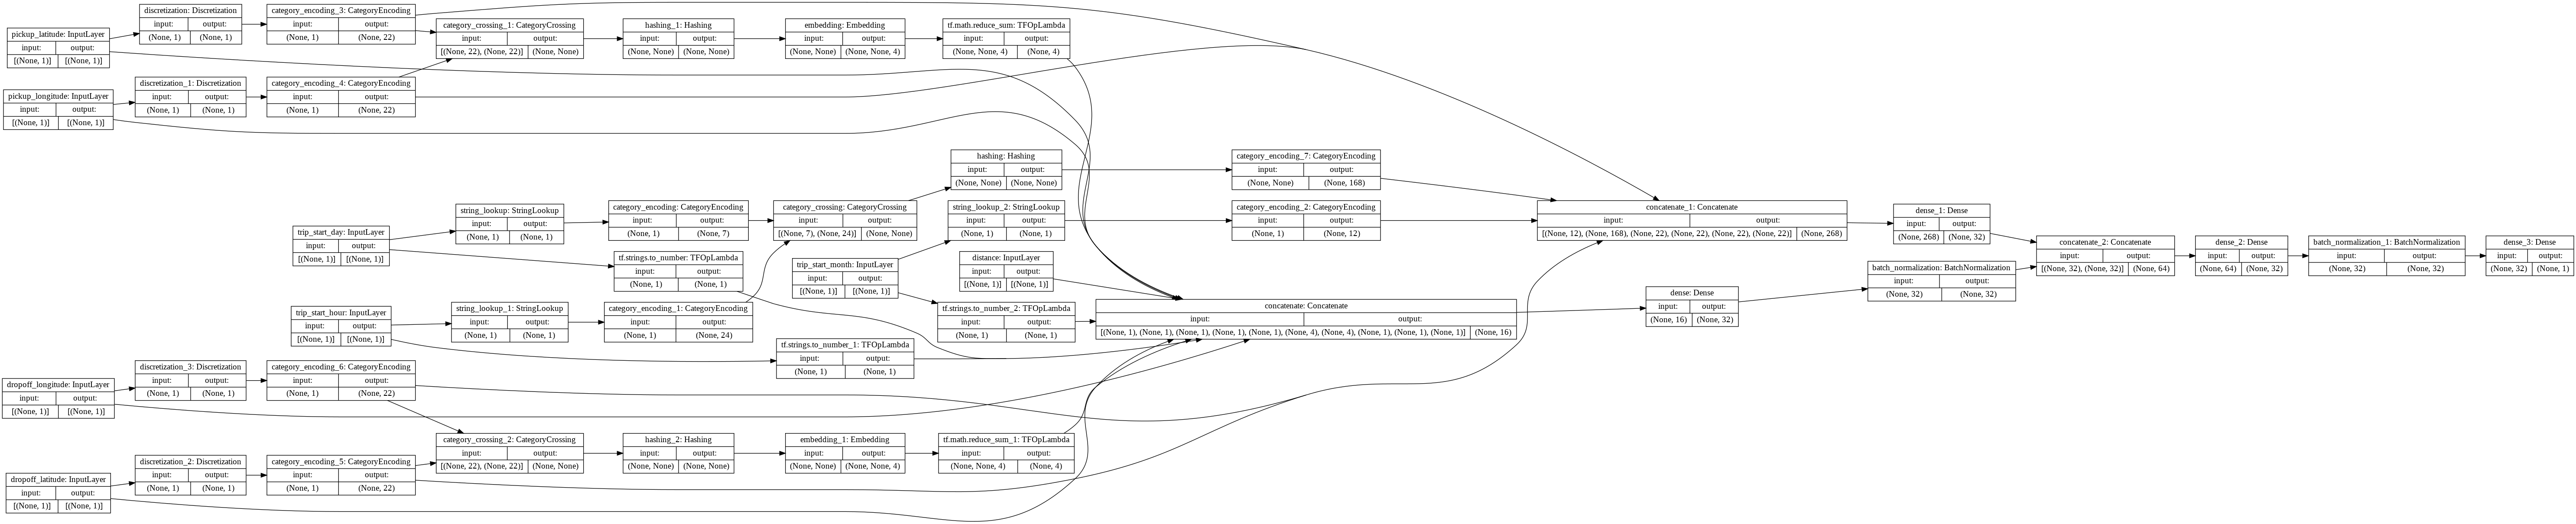

In [ ]:
#Create dataset input functions jagruti changed validation dataset bactsize to 128
train_dataset = make_input_fn(filename = 'train*.csv',
                    mode = tf.estimator.ModeKeys.TRAIN,
                    # vnum_epochs = epochs,
                    batch_size = 128)()

validation_dataset = make_input_fn(filename = 'eval*.csv',
                    mode = tf.estimator.ModeKeys.EVAL,
                    # vnum_epochs = 1,
                    batch_size = 128)()

m_ = create_keras_model(params = params_default, feature_cols = create_feature_cols())
tf.keras.utils.plot_model(m_, show_shapes=True, rankdir="LR")

In [ ]:
# !rm -rf "./logs"
# %tensorboard --logdir "./logs"

#changed from 50 to 70 to increase the number of iterations for the dataset
keras_train_and_evaluate(m_, train_dataset, validation_dataset, 70)

Epoch 1/70
100/100 [==============================] - 32s 314ms/step - loss: 150.1437 - rmse: 12.2533 - val_loss: 152.1328 - val_rmse: 12.3342
Epoch 2/70
100/100 [==============================] - 31s 315ms/step - loss: 129.7137 - rmse: 11.3892 - val_loss: 424.6064 - val_rmse: 20.6060
Epoch 3/70
100/100 [==============================] - 31s 315ms/step - loss: 107.5674 - rmse: 10.3714 - val_loss: 1853.5117 - val_rmse: 43.0524
Epoch 4/70
100/100 [==============================] - 31s 314ms/step - loss: 111.6533 - rmse: 10.5666 - val_loss: 6945.5156 - val_rmse: 83.3397
Epoch 5/70
100/100 [==============================] - 31s 312ms/step - loss: 101.5861 - rmse: 10.0789 - val_loss: 8119.5415 - val_rmse: 90.1085
Epoch 6/70
100/100 [==============================] - 31s 315ms/step - loss: 102.3399 - rmse: 10.1163 - val_loss: 15712.6963 - val_rmse: 125.3503

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 7/70
100/100 [==============================] - 

In [ ]:
# ## Prediction directly using model's instance
# ## BUT HERE ALL FEATURES HAVE TO BE PASSED, EVEN THE Calculated ones
data = tf.data.Dataset.from_tensor_slices({'dropoff_latitude': [[41.920452]],
                         'dropoff_longitude': [[-87.679955]],
                         'pickup_latitude': [[41.952823]],
                         'pickup_longitude': [[-87.653244]],
                         'trip_start_day': [["1"]],
                         'trip_start_hour': [["5"]],
                         'trip_start_month': [["6"]],
                   #       'trip_miles': [[0.04196861]],
                         'distance':[[0.04196861]]})

m_.predict(data)

array([[0.]], dtype=float32)

In [ ]:
@tf.function
def serving(dropoff_latitude, dropoff_longitude, pickup_latitude, pickup_longitude, trip_start_day, trip_start_hour, trip_start_month):
    ##Feature engineering( calculate distance )
    distance = tf.cast( tf.sqrt((tf.abs(dropoff_latitude - pickup_latitude))**2 + (tf.abs(dropoff_longitude - pickup_longitude))**2), tf.float32)

    payload = {
        'dropoff_latitude': dropoff_latitude,
        'dropoff_longitude': dropoff_longitude,
        'pickup_latitude': pickup_latitude,
        'pickup_longitude': pickup_longitude,
        'trip_start_day': trip_start_day,
        'trip_start_hour': trip_start_hour,
        'trip_start_month': trip_start_month,
        'distance': distance
    }
    
    ## Predict
    ##IF THERE IS AN ERROR IN NUMBER OF PARAMS PASSED HERE OR DATA TYPE THEN IT GIVES ERROR, "COULDN'T COMPUTE OUTPUT TENSOR"
    predictions = m_(payload)
    return predictions

serving = serving.get_concrete_function(trip_start_day=tf.TensorSpec([None,], dtype= tf.string, name='trip_start_day'), 
                                        trip_start_hour=tf.TensorSpec([None,], dtype= tf.string, name='trip_start_hour'),
                                        trip_start_month=tf.TensorSpec([None], dtype= tf.string, name='trip_start_month'), 
                                        dropoff_latitude=tf.TensorSpec([None,], dtype= tf.float32, name='dropoff_latitude'),
                                        dropoff_longitude=tf.TensorSpec([None,], dtype= tf.float32, name='dropoff_longitude'), 
                                        pickup_latitude=tf.TensorSpec([None,], dtype= tf.float32, name='pickup_latitude'),
                                        pickup_longitude=tf.TensorSpec([None,], dtype= tf.float32, name='pickup_longitude')
                                        )

version = "1"  #{'serving_default': call_output}
tf.saved_model.save(
    m_,
    "./exported_model/" + version,
    signatures=serving
) 

# tf.saved_model.save(
#     m_,
#     "./exported_model/" + version,
#     signatures={'serving_default': serving}
# ) 

INFO:tensorflow:Assets written to: ./exported_model/1/assets


In [ ]:
# !zip -r /content/model.zip /content/exported_model/1
!tar -cvf /content/model.tar /content/exported_model/1/

tar: Removing leading `/' from member names
/content/exported_model/1/
/content/exported_model/1/assets/
/content/exported_model/1/saved_model.pb
/content/exported_model/1/variables/
/content/exported_model/1/variables/variables.data-00000-of-00001
/content/exported_model/1/variables/variables.index


In [ ]:
##Check signature
!saved_model_cli show --dir "./exported_model/1" --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['dropoff_latitude'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1)
        name: serving_default_dropoff_latitude:0
    inputs['dropoff_longitude'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1)
        name: serving_default_dropoff_longitude:0
    inputs['pickup_latitude'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1)
        name: serving_default_pickup_latitude:0
    inputs['pickup_longitude'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1)
 

In [ ]:
#LOCAL: Predict using Keras prediction function
saved_mod = tf.saved_model.load("./exported_model/" + version)

#Get prediction function from serving
f = saved_mod.signatures['serving_default']

#Run prediction function from serving
f(dropoff_latitude=tf.convert_to_tensor([41.920452]), dropoff_longitude = tf.convert_to_tensor([-87.679955]), pickup_latitude = tf.convert_to_tensor([41.952823]), 
  pickup_longitude =tf.convert_to_tensor([-87.653244]), trip_start_day=tf.convert_to_tensor(["1"]), trip_start_hour=tf.convert_to_tensor(["5"]),
  trip_start_month=tf.convert_to_tensor(["6"]))

{'output_0': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.]], dtype=float32)>}

In [ ]:
###Install TF Model server

# This is the same as you would do from your command line, but without the [arch=amd64], and no sudo
# You would instead do:
# echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && \
# curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -

!apt-get remove tensorflow-model-server
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

!apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package tensorflow-model-server
deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0  20580      0 --:--:-- --:--:-- --:--:-- 20580
OK
Get:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:5 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:7 http://ppa.launchpad.net/deadsnakes/pp

In [ ]:
###Start Tensorflow server
# %%bash --bg 
# export TF_CPP_MIN_VLOG_LEVEL=0

%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8505 \
  --model_name=model \
  --model_base_path="/content/exported_model" >server.log 2>&1

Starting job # 0 in a separate thread.


In [ ]:
!tail server.log

In [ ]:
import json
import requests

#Create payload
data_py = {"instances":[{'dropoff_latitude': [41.920452],
                         'dropoff_longitude': [-87.679955],
                         'pickup_latitude': [41.952823],
                         'pickup_longitude': [-87.653244],
                         'trip_start_day': ["1"],
                         'trip_start_hour': ["5"],
                         'trip_start_month': ["6"]}]}

data = json.dumps(data_py)
print("payload: ", data)

#Run request on TMS
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8505/v1/models/model:predict', data=data, headers=headers)
json_response.text

payload:  {"instances": [{"dropoff_latitude": [41.920452], "dropoff_longitude": [-87.679955], "pickup_latitude": [41.952823], "pickup_longitude": [-87.653244], "trip_start_day": ["1"], "trip_start_hour": ["5"], "trip_start_month": ["6"]}]}


ConnectionError: ignored